In [215]:
# imports

%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from matplotlib.ticker import AutoLocator, MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift
import csv

sys.path.append('../../pyVisOS/')
sys.path.append('../')
import osh5def
import osh5io
import osh5vis
import osh5utils

import Plot

In [216]:
c = 299792458*1e6*1e-15 # um / fs, speed of light
lamda = .8 # um
om_0 = 2*np.pi*c/lamda # 1/fs, ~2.36
density = 0.7
L1 = 150 # c/omega_p
L2 = L1 * c/om_0 # um

In [217]:
# clear previous diagnostics
os.system('rm -rf MS/ TIMINGS/')

# run osiris simulation
os.system('../../osiris/bin/osiris-1D.e refractive.1d')

 Osiris running on host avrutskys-mbp
 Current working directory = /Users/avrutsky/College/Lab/simulations/refractive
 Timer resolution is    3.4000000000000000E-008  seconds
 
 ***************************************************************
 *          Using double precision AVX optimized Code          *
 ***************************************************************
 
 Software revision: r4f85ea0
 
 
 Reading input file, full name: refractive.1d
 
 Reading global simulation options... 
 Reading parallel node configuration... 
 Reading grid configuration...
 cartesian coordinates
 Reading tstep configuration... 
 Reading restart configuration... 
 Reading g_space configuration... 
 Reading time configuration... 
 Reading emf configuration... 
  - no smoothing specified
 Reading part configuration... 
 - species (1) configuration...
    Species name : electrons
 Reading zpulses ... 
  - Reading zpulse configuration...
 Reading current configuration...
  - no smoothing specified
  - no

0

In [218]:
def timeslice(ax, data, xpos, **kwargpassthrough):
    """Plots E field at a given position over time
    ax: Axes to plot on
    data: 2d array holding xt data
    xpos: x position (measured in c/omega_p) to plot at
    **kwargpassthrough: additional plotting parameters"""

    xindex = np.argwhere(np.abs(data.axes[1].ax - xpos) < 0.1)[0][0]
    t = data.axes[0].ax
    ax.plot(t, data[:, xindex], **kwargpassthrough)
    ax.set(title=r'$%s$, $x = %.1f$ [$%s$]' % (data.long_name, xpos, data.axes[1].units),
            xlabel = r'$t$ [$%s$]' % data.axes[0].units)

    return data[:, xindex]

def timeslice2(ax, data, xpos, **kwargpassthrough):
    """Plots E field at a given position over time
    ax: Axes to plot on
    data: 2d array holding xt data
    xpos: x position (measured in um) to plot at
    **kwargpassthrough: additional plotting parameters"""
    
    xindex = np.argwhere(np.abs(data.axes[1].ax*lamda/2/np.pi - xpos) < 0.1)[0][0]
    
    t = data.axes[0].ax / om_0
    ax.plot(t, data[:, xindex], **kwargpassthrough)
    ax.set(title=r'$%s$, $x = %.1f$ [$\mu m$]' % (data.long_name, xpos),
            xlabel = r'$t$ [fs]')

    return data[:, xindex]

[0.00000000e+00 1.01904794e-01 2.03809588e-01 ... 4.17096322e+02
 4.17198227e+02 4.17300132e+02]
[4.17300132e+02 4.17198227e+02 4.17096322e+02 ... 2.03809588e-01
 1.01904794e-01 0.00000000e+00]
4096 8192 8192


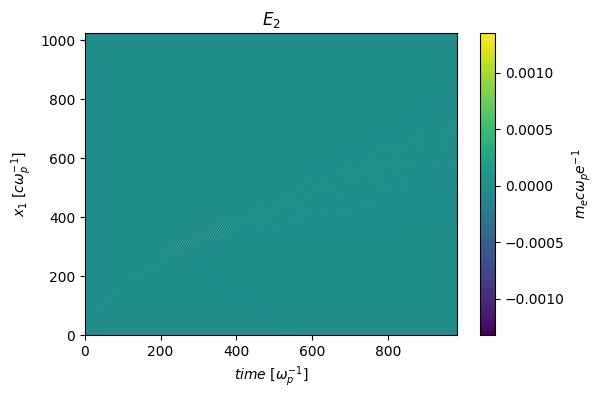

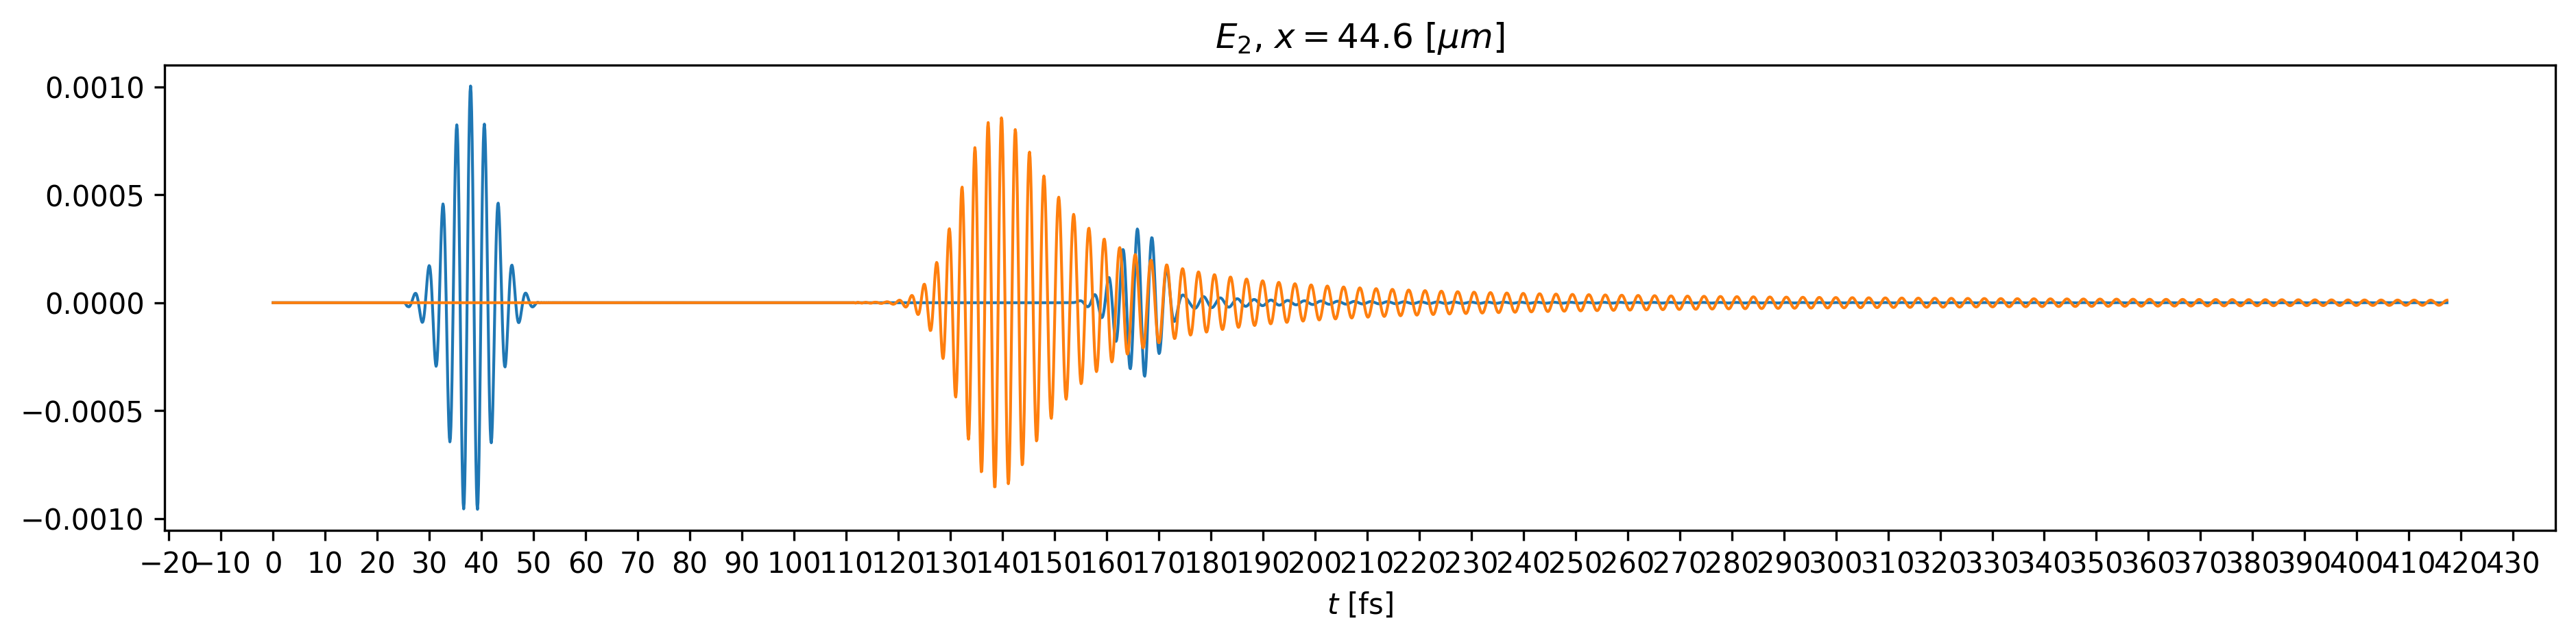

In [219]:
fig, ax = plt.subplots(1, 1, dpi=100)
data, _ = Plot.xt(ax, 'e2');
t = data.axes[0].ax / om_0
# each row is a time, each column is an x coordinate
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(15,3))
E1 = timeslice2(ax, data, 150* lamda/2/np.pi, linewidth=1)
E2 = np.array(E1)#timeslice2(ax, data, 150* lamda/2/np.pi, linewidth=0.2)
E3 = timeslice2(ax, data, 350* lamda/2/np.pi, linewidth=1)

E1 = np.where(t < 200/om_0, E1, np.zeros_like(E1))
E2 = np.where(t > 200/om_0, E2, np.zeros_like(E2))
E3 = np.where(t > 200/om_0, E3, np.zeros_like(E3))

E4 = np.concatenate((np.zeros_like(E1), E1))
E5 = np.concatenate((np.zeros_like(E2), E2))
E6 = np.concatenate((np.zeros_like(E3), E3))

print(t)
print(t[::-1])
t2 = np.concatenate((-1*t[::-1], t))

ax.xaxis.set_major_locator(MultipleLocator(10))
print(len(E1), len(E4), len(t2))

In [220]:
N = len(t2)
delta_t = t2[2]-t2[1]
delta_omega = 2*np.pi/(N*delta_t)

print('Δt =', delta_t)
print('Δω =', delta_omega)

F1 = fftshift(fft(E4) * delta_t)
F2 = fftshift(fft(E5) * delta_t)
F3 = fftshift(fft(E6) * delta_t)
w = fftshift(fftfreq(E4.size, d=delta_t) * 2*np.pi)# * om_0

Δt = 0.10190479403479458
Δω = 0.0075265388758936885


In [221]:
print(np.argwhere(w > 1.7)[0][0])
print(np.argwhere(w > 3.0)[0][0])


4322
4495


8192


/var/folders/0q/92tl0cqd1qjfvklm8_p_x7wr0000gn/T/ipykernel_13075/1660331806.py:18: RuntimeWarning: invalid value encountered in sqrt
  n_theo = np.sqrt(1-density*om_0**2/(w_peaks**2))


[Text(0.5, 1.0, 'N =0.7')]

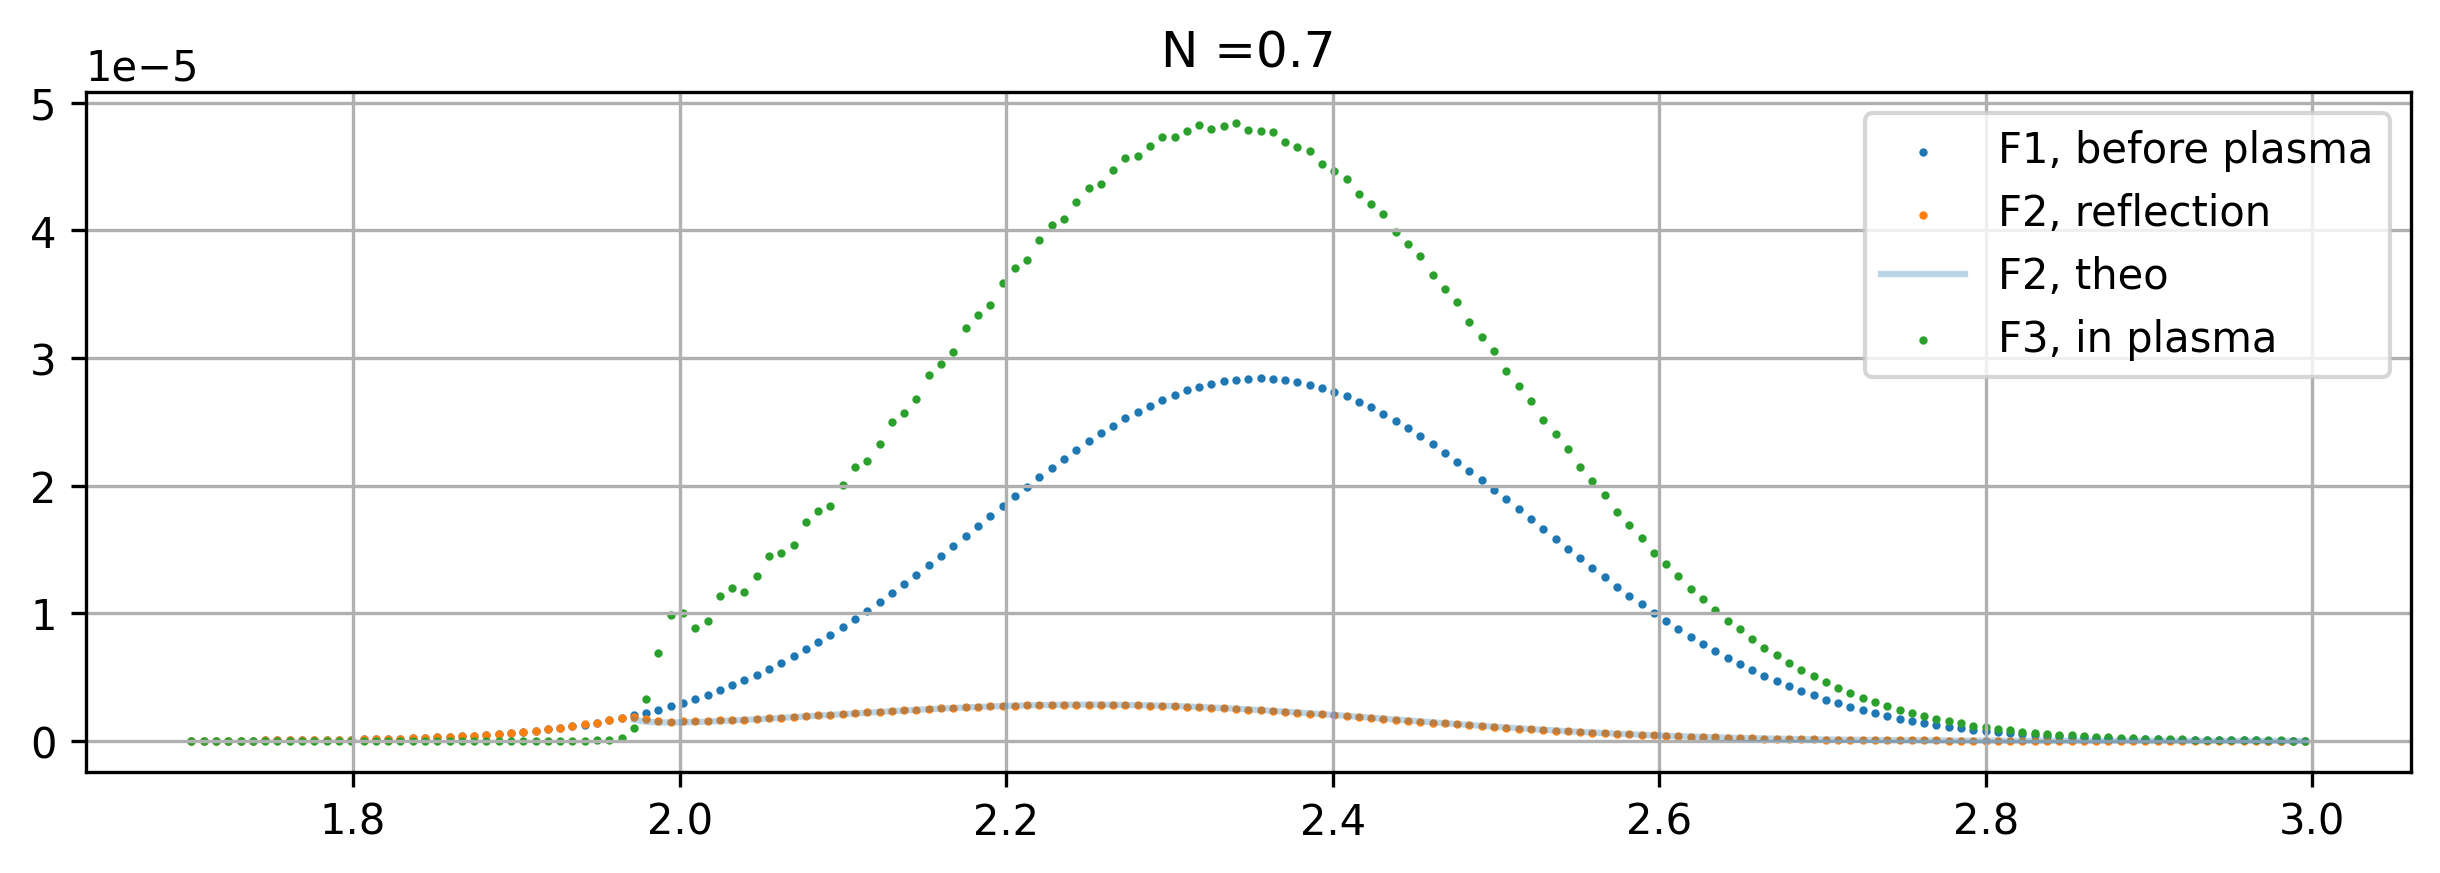

In [222]:
print(len(F1))
threshold = 1e-8
start = np.argwhere(w > 1.7)[0][0]
end = np.argwhere(w > 3.0)[0][0]

w_peaks = w[start:end]
F1_peaks = F1[start:end]
F2_peaks = F2[start:end]
F3_peaks = F3[start:end]


F1_peaks = F1_peaks[w_peaks >= 0]
F2_peaks = F2_peaks[w_peaks >= 0]
F3_peaks = F3_peaks[w_peaks >= 0]
w_peaks = w_peaks[w_peaks >= 0]


n_theo = np.sqrt(1-density*om_0**2/(w_peaks**2))
F2_theo = F1_peaks * np.exp(-1j*w_peaks*2*L2/c) * (1-n_theo)/(1+n_theo)


fig, ax = plt.subplots(figsize=(10,3), dpi=300)
ax.scatter(w_peaks, np.abs(F1_peaks)**2, s=1, label='F1, before plasma')
ax.scatter(w_peaks, np.abs(F2_peaks)**2, s=1, label='F2, reflection')
ax.plot(w_peaks, np.abs(F2_theo)**2, alpha=0.3, label='F2, theo')
ax.scatter(w_peaks, np.abs(F3_peaks)**2, s=1, label='F3, in plasma')
ax.legend()
#ax.xaxis.set_major_locator(MultipleLocator(2*np.pi/165))
ax.grid()
ax.set(title='N ='+str(density))

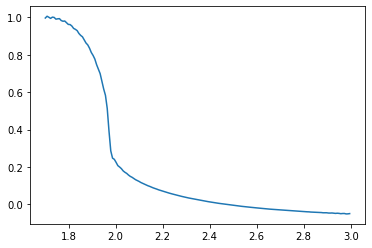

In [223]:
fig, ax = plt.subplots()

ax.plot(w_peaks, F2_peaks / (F1_peaks * np.exp(-1j*w_peaks/c*2*L2)))

$$F_2(\omega) + F_2(\omega)*n(\omega) = F_1(\omega)*e^{-i*\omega/c*2L_1} - F_1(\omega)*e^{-i*\omega/c*2L_1}*n(\omega)$$

$$n(\omega) * (F_2(\omega)* + F_1(\omega)*e^{-i*\omega/c*2L_1}) = F_1(\omega)*e^{-i*\omega/c*2L_1} - F_2(\omega)$$


$$n(\omega) = \frac{F_1(\omega)*e^{-i*\omega/c*2L_1} - F_2(\omega)}{(F_1(\omega)*e^{-i*\omega/c*2L_1} + F_2(\omega))}$$

1.969969962856973


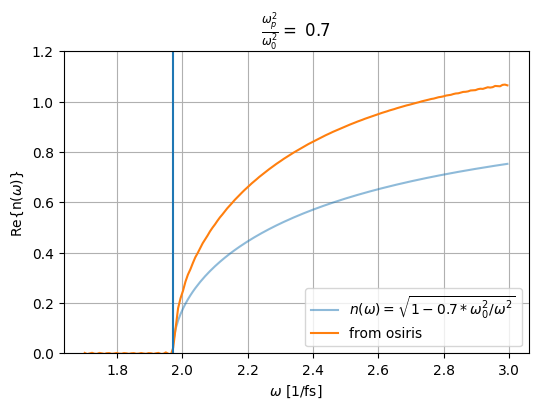

In [224]:
n = (F1_peaks * np.exp(-1j*w_peaks/c*L2*2) - F2_peaks) / (F1_peaks * np.exp(-1j*w_peaks/c*L2*2) + F2_peaks)
#n = np.where(np.abs(n) < 0.001, np.zeros_like(n), n)
print(np.sqrt(density)*(om_0))
fig, ax = plt.subplots(dpi=100)
ax.plot(w_peaks, n_theo, alpha=0.5, label=r'$n(\omega)=\sqrt{1-0.7*\omega_0^2/\omega^2}$')
ax.plot(w_peaks, np.real(n), label='from osiris')
ax.set(title=r'$\frac{\omega_p^2}{\omega_0^2} =$ '+str(density),
         xlabel=r'$\omega$ [1/fs]', ylabel=r'Re{n($\omega$)}',
         ylim=[0,1.2])
ax.axvline(np.sqrt(density)*om_0)
ax.legend()
ax.grid()

In [225]:
print(np.sqrt(density))

0.8366600265340756


In [226]:
fout = open('./n/'+str(density).replace('.', '-')+'.csv', 'w')
writer = csv.writer(fout)
writer.writerow(['ω [1/fs]','ω [ω_0]','Re{n(ω)}', 'Im{n(ω)}'])

for i in range(len(w_peaks)):
    if np.real(n)[i] < 0 and w_peaks[i] >= np.sqrt(density)*om_0:
        print(i, '!')
    if w_peaks[i] < np.sqrt(density)*om_0:
        writer.writerow([w_peaks[i], w_peaks[i] / om_0, 0.0, np.imag(n)[i]])
    else:
        writer.writerow([w_peaks[i], w_peaks[i] / om_0, np.real(n)[i], np.imag(n)[i]])

fout.close()

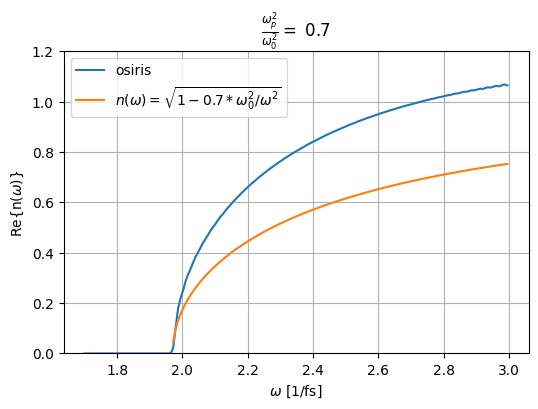

In [242]:
fnms = []
fnms = os.listdir('n/')
fnms.sort()

fig, ax = plt.subplots(dpi=100)

# plot all
if False:
    for i in fnms[:]:
        temp = np.genfromtxt('n/'+i, delimiter=',', skip_header=1, names=['omega', 'omega2', 'ReN', 'ImN'])
        ax.scatter(temp['omega'], temp['ReN'], label=i[:3], s=1)

ns = 0.7
if True:
    temp = np.genfromtxt('n/'+str(ns).replace('.', '-')+'.csv', delimiter=',', skip_header=1, names=['omega', 'omega2', 'ReN', 'ImN'])
    ax.plot(temp['omega'], temp['ReN'], label='osiris')
    ax.plot(w_peaks, n_theo, label=r'$n(\omega)=\sqrt{1-%.1f*\omega_0^2/\omega^2}$' % ns)
    ax.set(title=r'$\frac{\omega_p^2}{\omega_0^2} =$ '+str(ns),
         xlabel=r'$\omega$ [1/fs]', ylabel=r'Re{n($\omega$)}',
         ylim=[0,1.2])
ax.grid()
ax.legend()